In [228]:
# Modules
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import tensorflow as tf
import skfuzzy as fuzz
import nibabel as nib
import seaborn as sns
import numpy as np
import itertools
import warnings
import skimage
import imageio
import json
import time
import cv2
import sys
import os

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Lambda, concatenate
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.metrics import MeanIoU, Precision, Recall
from skimage import filters, segmentation, color, measure
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from miseval import evaluate
from io import BytesIO

# Custom Modules
from morphology.region_growing import region_growing
from morphology.fuzzy_cmeans import fuzzy_cmeans
from morphology.felzenszwalb import felzenszwalb
from morphology.watershed import watershed
from morphology.slic import slic

%matplotlib inline
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Versions of each imported module
# for debug only

#import scipy
#import matplotlib

# for name, module in globals().items():
#     if isinstance(module, type(sys)):
#         try:
#             print(f"{name}: {module.__version__} - was loaded")
#         except AttributeError:
#             print(f"{name}: Version not found - was loaded")

# Exploratory Data Analysis

In [2]:
# Loading all three Sequence Volumes
t1_vol = nib.load("Datasets/ds004199/sub-00001/anat/sub-00001_acq-iso08_T1w.nii.gz")
t2_vol = nib.load("Datasets/ds004199/sub-00001/anat/sub-00001_acq-T2sel_FLAIR.nii.gz")
t2roi_vol = nib.load("Datasets/ds004199/sub-00001/anat/sub-00001_acq-T2sel_FLAIR_roi.nii.gz")

t2_data = t2_vol.get_fdata()
t2roi_data = t2roi_vol.get_fdata()

In [5]:
# T2 Volume Information
t2_hdr = t2_vol.header

print(t2_hdr)
print(t2_vol.shape)

t2_hdr.get_zooms() # voxel size
t2_hdr.get_xyzt_units() # unit of time and space

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 54
dim             : [  3 160 256 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1. 1. 1. 1. 5. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'TE=3.9e+02;Time=105309.565;phase=1'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.052856393
quatern_c       : -0.033188943
quatern_d       : -0.01936007
qoffset_x       : -75.682396
qoffset_y       : -83.82628
qoff

('mm', 'sec')

In [6]:
# T2 Label Volume Information
t2roi_hdr = t2roi_vol.header

print(t2roi_hdr)
print(t2roi_vol.shape)

t2roi_hdr.get_zooms() # voxel size
t2roi_hdr.get_xyzt_units() # unit of time and space

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 160 256 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : label
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1. 1. 1. 1. 0. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 4.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FSL4.0'
aux_file        : b'Red-Yellow '
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.052856393
quatern_c       : -0.033188943
quatern_d       : -0.01936007
qoffset_x       : -75.68236
qoffset_y       : -83.826294
qoffset_z       : -13

('mm', 'sec')

[[1.00233463 0.         0.         ... 0.         0.         0.        ]
 [1.00233463 1.00233463 1.00233463 ... 0.         0.         0.        ]
 [1.00233463 1.00233463 1.00233463 ... 1.00233463 0.         0.        ]
 ...
 [1.00233463 1.00233463 1.00233463 ... 0.         0.         0.        ]
 [1.00233463 0.         1.99844358 ... 0.         0.         0.        ]
 [3.00077821 4.99922179 1.99844358 ... 0.         0.         0.        ]]


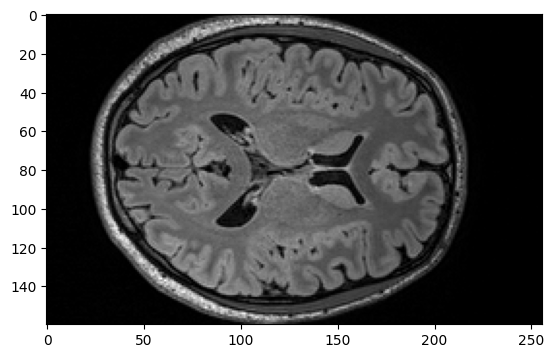

In [7]:
# Print image
plt.imshow(t2_data[:,:,135], cmap="gray")
print(t2_data[:,:,135])

Text(0.5, 1.0, 'T2 with lesion mask - Slice:135')

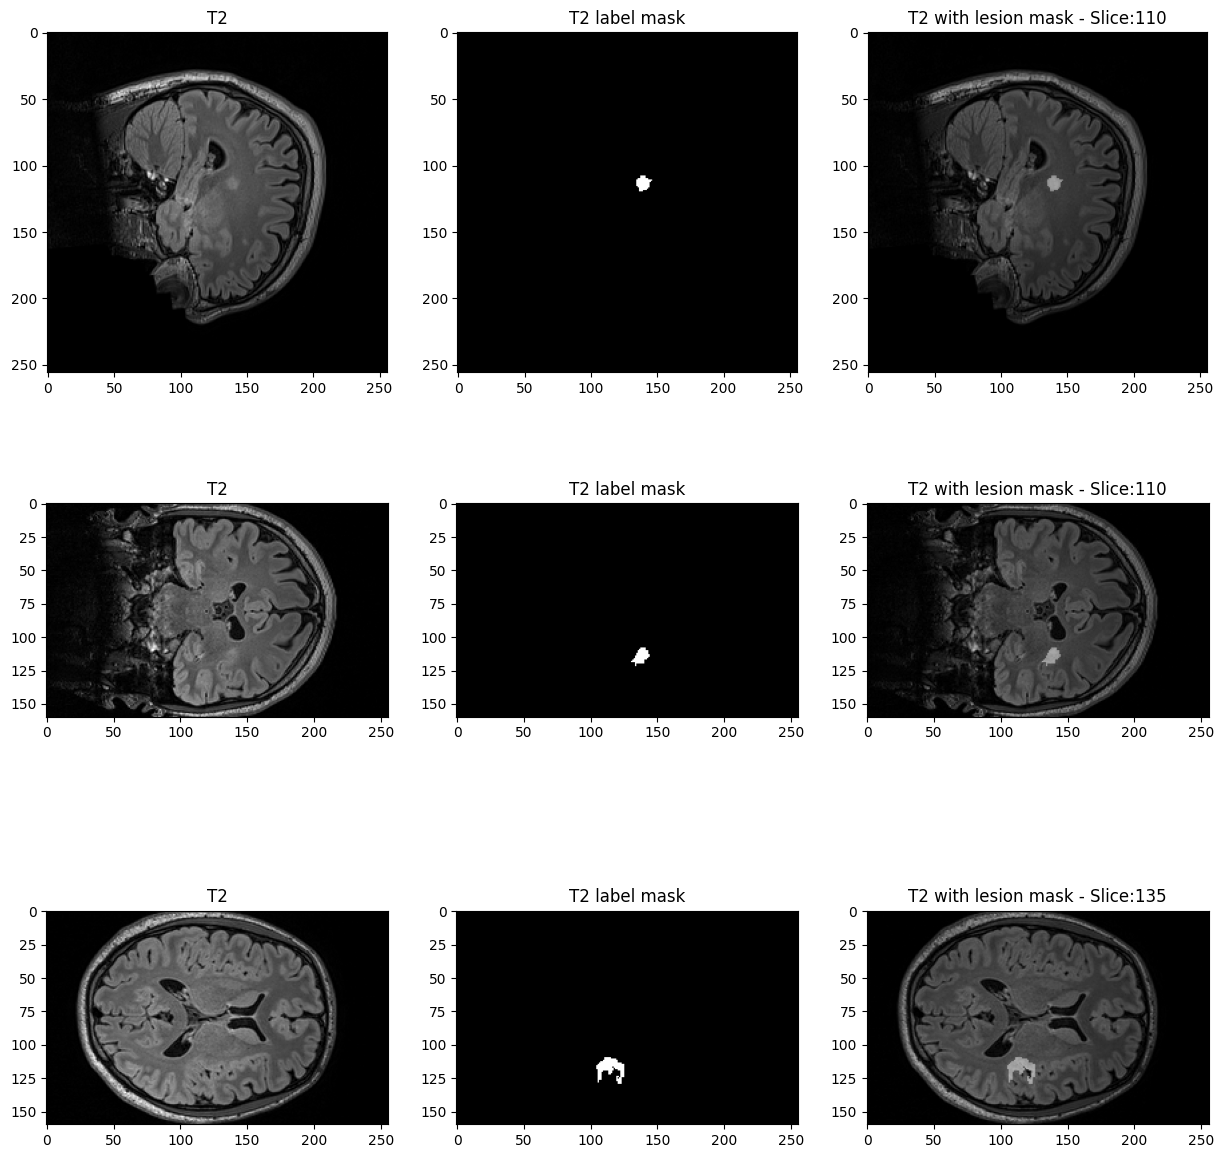

In [13]:
# Plot some slices of all axes of T2 Volume and T2 Label Volume ontop of T2 Volume

plt.figure(figsize=(15, 15))

sliceNum = 110

plt.subplot(3, 3, 1)
plt.imshow(t2_data[sliceNum, :, :], cmap="gray")
plt.title("T2 - Sagittal")

plt.subplot(3, 3, 2)
plt.imshow(t2roi_data[sliceNum, :, :], cmap="gray")
plt.title(f"T2 label mask")

plt.subplot(3, 3, 3)
plt.imshow(t2_data[sliceNum, :, :], cmap="gray")
plt.imshow(t2roi_data[sliceNum, :, :], cmap="gray", alpha=0.3)
plt.title(f"T2 with lesion mask - Slice:{sliceNum}")

sliceNum = 110

plt.subplot(3, 3, 4)
plt.imshow(t2_data[:, sliceNum, :], cmap="gray")
plt.title("T2 - Coronal")

plt.subplot(3, 3, 5)
plt.imshow(t2roi_data[:, sliceNum, :], cmap="gray")
plt.title(f"T2 label mask")

plt.subplot(3, 3, 6)
plt.imshow(t2_data[:, sliceNum, :], cmap="gray")
plt.imshow(t2roi_data[:, sliceNum, :], cmap="gray", alpha=0.3)
plt.title(f"T2 with lesion mask - Slice:{sliceNum}")

sliceNum = 135

plt.subplot(3, 3, 7)
plt.imshow(t2_data[:, :, sliceNum], cmap="gray")
plt.title("T2 - Transverse")

plt.subplot(3, 3, 8)
plt.imshow(t2roi_data[:, :, sliceNum], cmap="gray")
plt.title(f"T2 label mask")

plt.subplot(3, 3, 9)
plt.imshow(t2_data[:, :, sliceNum], cmap="gray")
plt.imshow(t2roi_data[:, :, sliceNum], cmap="gray", alpha=0.3)
plt.title(f"T2 with lesion mask - Slice:{sliceNum}")



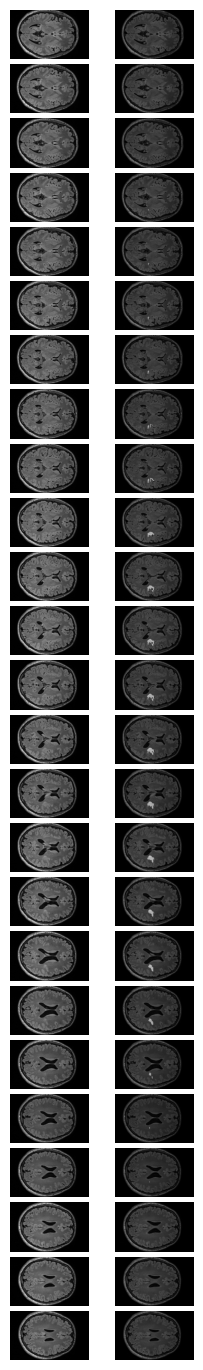

In [9]:
plt.figure(figsize=(5, 15))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=.5,
                    top=1,
                    wspace=0.1,
                    hspace=0.1)

for i in range(0, 25):
    plt.subplot(25, 2, i*2+1)
    plt.imshow(t2_data[:, :, 125+i], cmap="gray")
    plt.axis("off")

    plt.subplot(25, 2, i*2+2)
    plt.imshow(t2_data[:, :, 125+i], cmap="gray")
    plt.imshow(t2roi_data[:, :, 125+i], cmap="gray", alpha=0.4)
    plt.axis("off")

In [10]:
def gif_save(volume, mask, axis, name):
    frames  = []
    for i in range(volume.shape[axis]):
        fig, ax = plt.subplots(figsize=(5, 5))
        
        if axis == 0:
            ax.imshow(volume[i, :, :], cmap="gray")
            ax.imshow(mask[i, :, :], cmap="gray", alpha=0.4)
            ax.set_title(f"{name} - Slice {i}")
            ax.axis("off")
        elif axis == 1:
            ax.imshow(volume[:, i, :], cmap="gray")
            ax.imshow(mask[:, i, :], cmap="gray", alpha=0.4)
            ax.set_title(f"{name} - Slice {i}")
            ax.axis("off")
        elif axis == 2:
            ax.imshow(volume[:, :, i], cmap="gray")
            ax.imshow(mask[:, :, i], cmap="gray", alpha=0.4)
            ax.set_title(f"{name} - Slice {i}")
            ax.axis("off")

        # Create a temporary buffer to capture the plot content
        buf = BytesIO()
        plt.savefig(buf, format="png", dpi=100)  # Save plot to buffer
        buf.seek(0)
        frame = imageio.v2.imread(buf) 
        frames.append(frame)
        
        buf.close()
        plt.close()

    imageio.mimsave(f"images/{name}_mask.gif", frames, duration = 3)


gif_save(t2_data, t2roi_data, 0, "T2-axis1")

gif_save(t2_data, t2roi_data, 1, "T2-axis2")

gif_save(t2_data, t2roi_data, 2, "T2-axis3")

# Morphological Operations

### Pre-processing

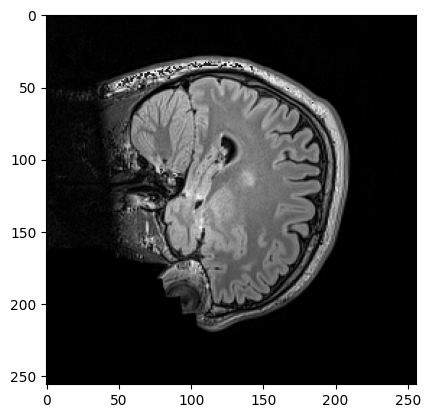

In [38]:
# Manual Image Selector
t2_vol = nib.load("Datasets/ds004199/sub-00001/anat/sub-00001_acq-T2sel_FLAIR.nii.gz")
t2roi_vol = nib.load("Datasets/ds004199/sub-00001/anat/sub-00001_acq-T2sel_FLAIR_roi.nii.gz")

t2_data = t2_vol.get_fdata()
t2roi_data = t2roi_vol.get_fdata()

def img_selector(axis, sliceNum):
    if axis == 0:
        image = t2_data[sliceNum, :, :]
        mask = t2roi_data[sliceNum, :, :]
    elif axis == 1:
        image = t2_data[:, sliceNum, :]
        mask = t2roi_data[:, sliceNum, :]
    elif axis == 2:
        image = t2_data[:, :, sliceNum]
        mask = t2roi_data[:, :, sliceNum]

    if image.dtype == np.float64:
        image = image.astype(np.uint8)
    if mask.dtype == np.float64:
        mask = mask.astype(np.uint8)
    
    return image, mask

sliceNum = 111
axis = 0

image, mask = img_selector(axis, sliceNum)

plt.imshow(image, cmap="gray")
plt.show()

# print(image.shape)
# print(mask.shape)

#### Seed Points from Label Image

In [2]:
# Finding Seeds

def find_seeds(label_mask):
    # convert float64 to uint8
    label_mask = (label_mask * 255).astype(np.uint8)
    # apply thresholding to make sure its binary
    _, binary_mask = cv2.threshold(label_mask, 127, 255, cv2.THRESH_BINARY)

    # find contours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    seed_points = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            seed_points.append((cY, cX))

    # # plot seed on label mask
    # plt.imshow(label_mask, cmap="gray")

    # # Loop through your seed points and plot them
    # for (y, x) in seed_points:
    #     plt.scatter(x, y, color="red", s=2) 

    # plt.title(f"Seed Point on Label Mask at {seed_points[0]}")
    # plt.show()

    return seed_points

# seed_points = find_seeds(mask)

#### Crop Area

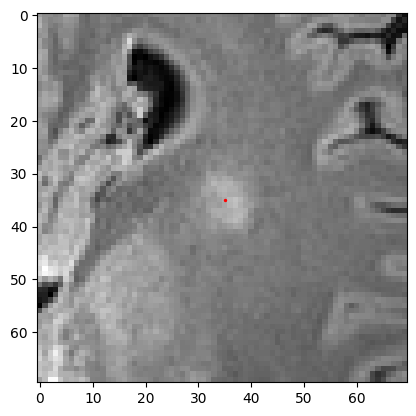

In [40]:
# Crop area around seed point
crop_dim = 35

def crop_area(image):
    crop_area = image[seed_points[0][0]- crop_dim: seed_points[0][0] + crop_dim, seed_points[0][1] - crop_dim: seed_points[0][1] + crop_dim]
    return crop_area

adjusted_seed = (crop_dim,) * 2

plt.imshow(crop_area(image), cmap="gray")
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=2)

#### Histogram Equalization

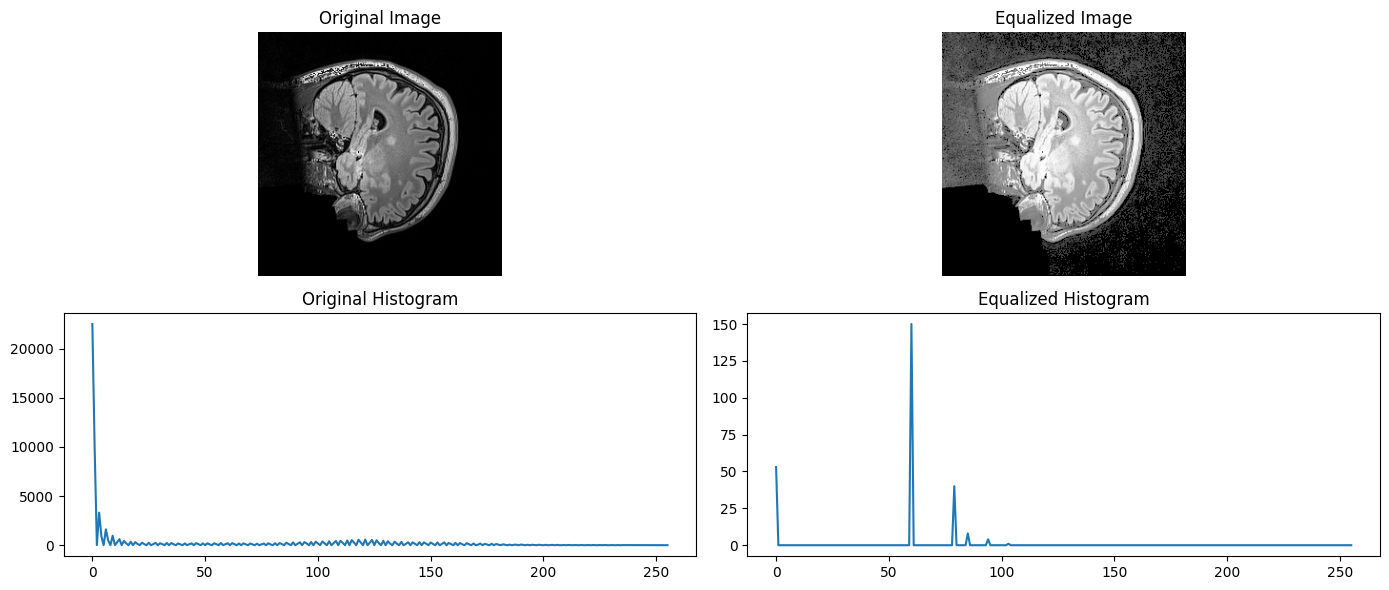

In [5]:
# Histogram Equalization

# Calculate the histogram of the image
histogram = cv2.calcHist([image], [0], None, [256], [0, 256])

# Perform histogram equalization
equalized_image = cv2.equalizeHist(image)

# Calculate the histogram of the equalized image
equalized_histogram = cv2.calcHist(equalized_image, [0], None, [256], [0, 256])

# Plot the original and equalized images and their histograms
fig, axs = plt.subplots(2, 2, figsize=(14, 6))

# Original image and histogram
axs[0, 0].imshow(image, cmap="gray")
axs[0, 0].set_title("Original Image")
axs[0, 0].axis("off")

axs[1, 0].plot(histogram)
axs[1, 0].set_title("Original Histogram")

# Equalized image and histogram
axs[0, 1].imshow(equalized_image, cmap="gray")
axs[0, 1].set_title("Equalized Image")
axs[0, 1].axis("off")

axs[1, 1].plot(equalized_histogram)
axs[1, 1].set_title("Equalized Histogram")

plt.tight_layout()
plt.show()

#### Gaussian Filtering

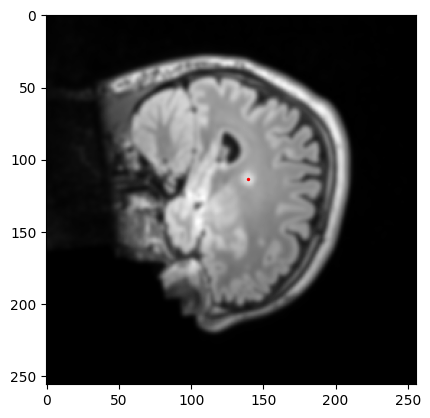

In [6]:
gaussian_image = filters.gaussian(image, sigma=1.5)  # Adjust sigma as needed

plt.imshow(gaussian_image, cmap="gray")
for (y, x) in seed_points:
    plt.scatter(x, y, color="red", s=2)
plt.show()

#### Frangi Filter

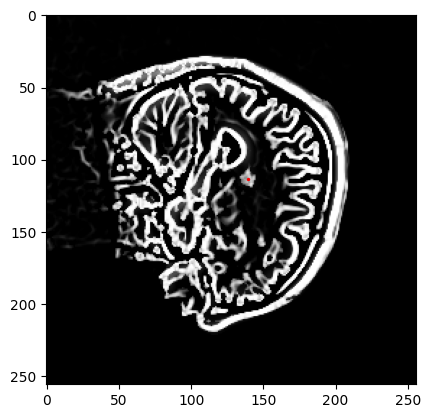

In [7]:
filtered_image = filters.frangi(image, sigmas=(5, 1.75), scale_step=1, beta=1, gamma=1.5, black_ridges=False)

plt.imshow(filtered_image, cmap="gray")
for (y, x) in seed_points:
    plt.scatter(x, y, color="red", s=2)
plt.show()


### Performance Evaluation

In [199]:
def eval_scores(mask, segment, eval_type):
    return evaluate(mask, segment, metric=eval_type)

def eval_print_scores(mask, segment):
    print("Dice Score: ", evaluate(mask, segment, metric="DSC"))
    print("IoU Score: ", evaluate(mask, segment, metric="IoU"))
    print("Sensitivity Score: ", evaluate(mask, segment, metric="SENS"))
    print("Specificity Score: ", evaluate(mask, segment, metric="SPEC"))
    print("Precision Score: ", evaluate(mask, segment, metric="PREC"))
    print("Accuracy Score: ", evaluate(mask, segment, metric="ACC"))
    print("Average Hausdorff Distance: ", evaluate(mask, segment, metric="AHD"))

### Region-Growing

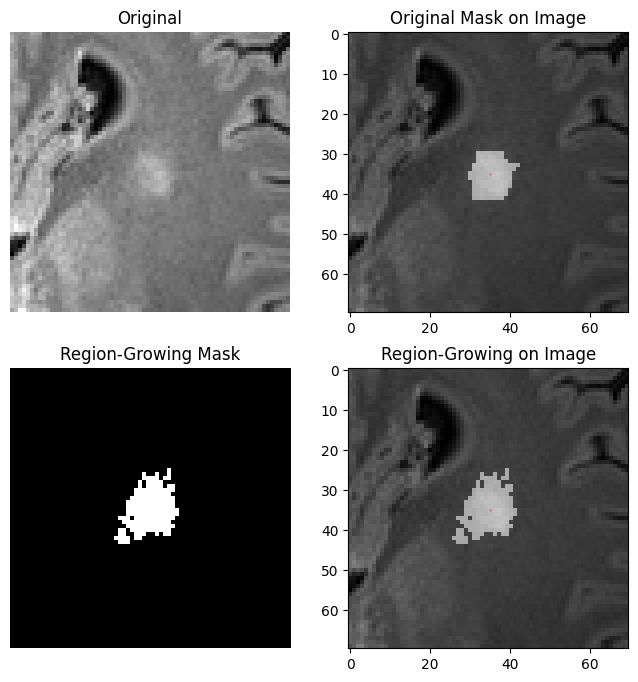

Dice Score:  0.7544483985765125
IoU Score:  0.6057142857142858
Sensitivity Score:  0.9380530973451328
Specificity Score:  0.9870482556925005
Precision Score:  0.6309523809523809
Average Hausdorff Distance:  5.0990195135927845


In [41]:
def region_growing_single(image, seed, threshold):
    height, width = image.shape
    region = np.zeros_like(image, dtype=np.uint8) 
    points_to_visit = [seed]

    # The mean intensity of the region; starting with the seed intensity
    region_mean = float(image[seed])
    region[seed] = 255

    neighbours = [(1, 0), (-1, 0), (0, 1), (0, -1), (1, 1), (-1, -1), (1, -1), (-1, 1)]

    # Loop until there are no more points to visit
    while points_to_visit:
        y, x = points_to_visit.pop(0)

        # Check the neighbors of the current point
        for dy, dx in neighbours:
            ny, nx = y + dy, x + dx

            # Skip out-of-bounds or already added points
            if nx < 0 or ny < 0 or nx >= height or ny >= width or region[ny, nx] == 255:
                continue

            # Calculate intensity difference
            intensity_diff = abs(int(image[ny, nx]) - region_mean)

            if intensity_diff < threshold:
                region[ny, nx] = 255
                points_to_visit.append((ny, nx))
                # Recalculate the mean intensity of the region
                region_mean = ((region_mean * np.sum(region == 255)) + int(image[ny, nx])) / (np.sum(region == 255) + 1)

    return region

segmented_image = region_growing(crop_area(image), adjusted_seed, 22) / 255

plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.imshow(crop_area(image) , cmap="gray"), plt.title("Original"), plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(crop_area(image), cmap="gray")
plt.imshow(crop_area(mask), cmap="nipy_spectral", alpha=0.5)
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.title("Original Mask on Image")

plt.subplot(2, 2, 3)
plt.imshow(segmented_image , cmap="gray"), plt.title("Region-Growing Mask"), plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(crop_area(image), cmap="gray")
plt.imshow(segmented_image, cmap="nipy_spectral", alpha=0.5)
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=1, alpha=0.2)
plt.title("Region-Growing on Image")

plt.show()

eval_print_scores(crop_area(mask), segmented_image)

### Flooding and Watersheding

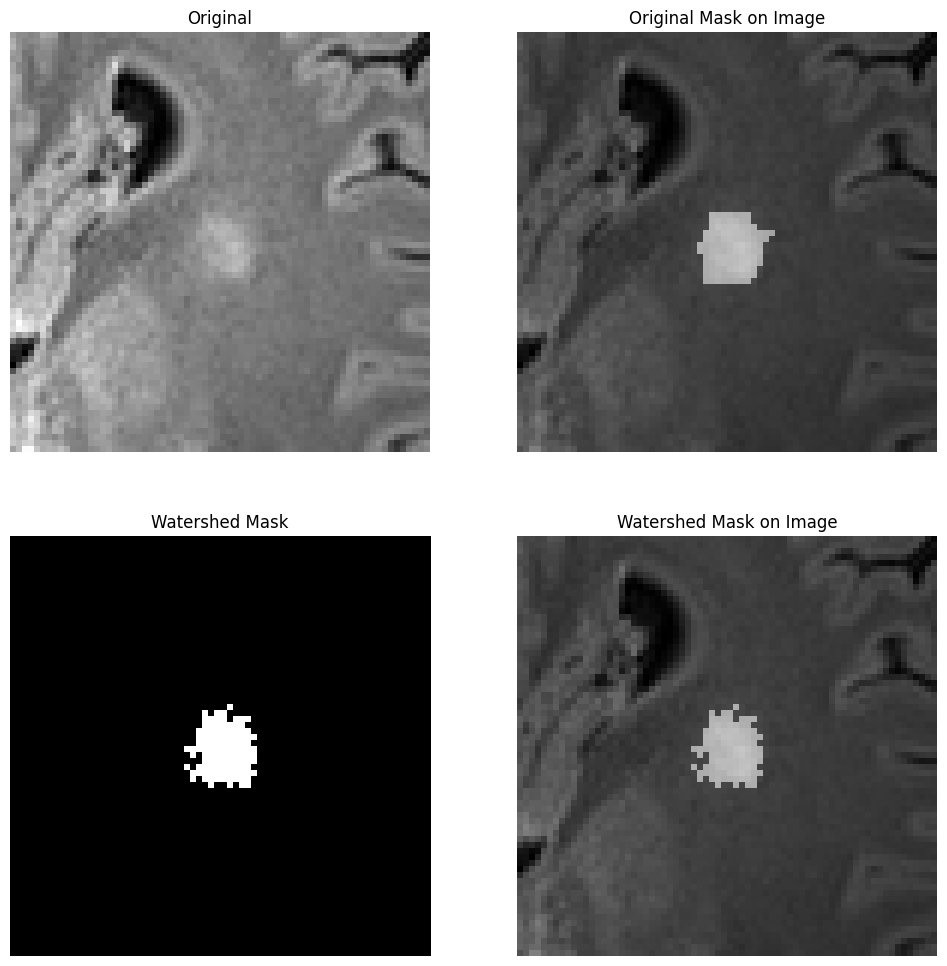

Dice Score:  0.8839285714285714
IoU Score:  0.792
Sensitivity Score:  0.8761061946902655
Specificity Score:  0.9974932107791936
Precision Score:  0.8918918918918919
Average Hausdorff Distance:  2.0


In [42]:
# Watershed Segmentation
labels = segmentation.flood(image, seed_points[0], connectivity=2, tolerance=30)

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.imshow(crop_area(image) , cmap="gray"), plt.title("Original"), plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(crop_area(image), cmap="gray")
plt.imshow(crop_area(mask), cmap="nipy_spectral", alpha=0.5)
# for (y, x) in seed_points:
#     plt.scatter(x, y, color="red", s=1, alpha=0.2)
plt.title("Original Mask on Image"), plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(crop_area(labels) , cmap="gray"), plt.title("Watershed Mask"), plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(crop_area(image), cmap="gray")
plt.imshow(crop_area(labels), cmap="nipy_spectral", alpha=0.5)
# for (y, x) in seed_points:
#     plt.scatter(x, y, color="red", s=1, alpha=0.2)
plt.title("Watershed Mask on Image"), plt.axis("off")

plt.show()

eval_print_scores(crop_area(mask), crop_area(labels))

### Fuzzy C-Means

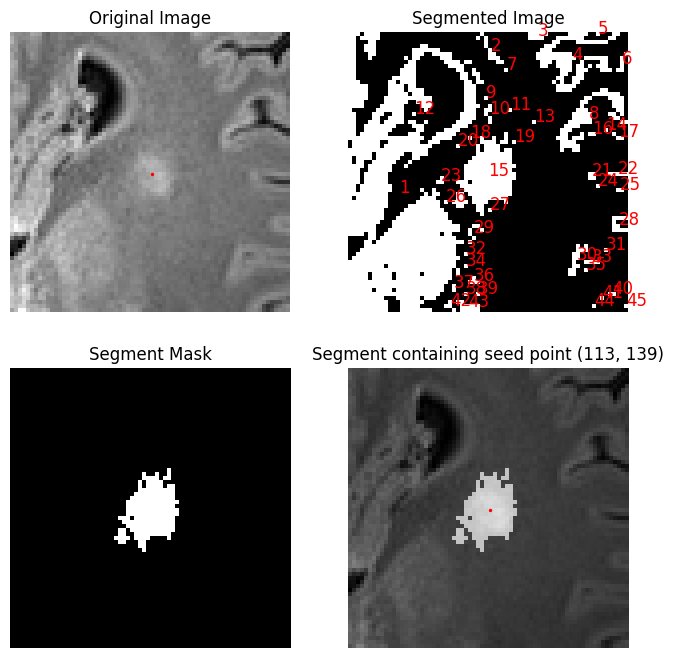

Dice Score:  0.7551020408163265
IoU Score:  0.6065573770491803
Sensitivity Score:  0.9823008849557522
Specificity Score:  0.9853770628786296
Precision Score:  0.6132596685082873
Average Hausdorff Distance:  5.0990195135927845


In [46]:
# FCM Segmentation

# Flatten image
shape = crop_area(image).shape
image_flattened = crop_area(image).reshape(-1)

# FCM
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    image_flattened.reshape(1, -1),
    2, # Number of clusters
    1.5, # Fuzziness parameter
    error=0.0001,
    maxiter=1000,
    init=None)

# cluster membership
labels = np.argmax(u, axis=0)
segmented_image = labels.reshape(shape)

labels = measure.label(segmented_image)
properties = measure.regionprops(labels)
# label of the segment at the seed point
seed_label = labels[adjusted_seed]
# Create a mask for the segment
segment_mask = labels == seed_label


plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.imshow(crop_area(image), cmap="gray"), plt.title("Original Image"), plt.axis("off")
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=2)

plt.subplot(2, 2, 2)
plt.imshow(segmented_image, cmap="gray"), plt.title("Segmented Image"), plt.axis("off")
for prop in properties:
    centroid = prop.centroid
    plt.text(centroid[1], centroid[0], str(prop.label), color="red", fontsize=12)

plt.subplot(2, 2, 3)
plt.imshow(segment_mask, cmap="gray"), plt.title("Segment Mask"), plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(crop_area(image), cmap="gray")
plt.imshow(segment_mask, cmap="gray", alpha=0.5), plt.title(f"Segment containing seed point {seed_points[0]}"), plt.axis("off")
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=2)

plt.show()

eval_print_scores(crop_area(mask), segment_mask)

### Felzenszwalb and SLIC Superpixels

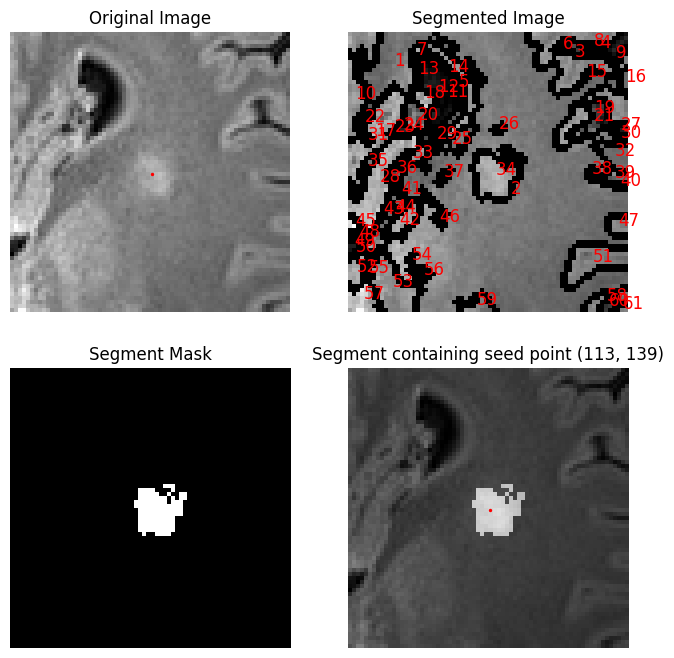

Dice Score:  0.8355555555555556
IoU Score:  0.7175572519083969
Sensitivity Score:  0.831858407079646
Specificity Score:  0.9962398161687904
Precision Score:  0.8392857142857143
Average Hausdorff Distance:  2.23606797749979


In [52]:
# Applying Felzenszwalb
segments_fz = segmentation.felzenszwalb(crop_area(image), scale=100, sigma=0.4, min_size=4)

# Creating Boundaries
label = segmentation.mark_boundaries(crop_area(image), segments_fz, (0, 0, 0),mode="thick")

# Find the unique segments and their centroids
regions = measure.regionprops(segments_fz)
centroids = [region.centroid for region in regions]

# Selecting a specific segment
selected_segment_id = segments_fz[adjusted_seed]
selected_segment = np.where(segments_fz == selected_segment_id, 1, 0)


plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.imshow(crop_area(image), cmap="gray"), plt.title("Original Image"), plt.axis("off")
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=2)

plt.subplot(2, 2, 2)
plt.imshow(label, cmap="gray"), plt.title("Segmented Image"), plt.axis("off")
for reg in regions:
    centroid = reg.centroid
    plt.text(centroid[1], centroid[0], str(reg.label), color="red", fontsize=12)

plt.subplot(2, 2, 3)
plt.imshow(selected_segment, cmap="gray"), plt.title("Segment Mask"), plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(crop_area(image), cmap="gray")
plt.imshow(selected_segment, cmap="gray", alpha=0.5), plt.title(f"Segment containing seed point {seed_points[0]}"), plt.axis("off")
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=2)

plt.show()

eval_print_scores(crop_area(mask), selected_segment)

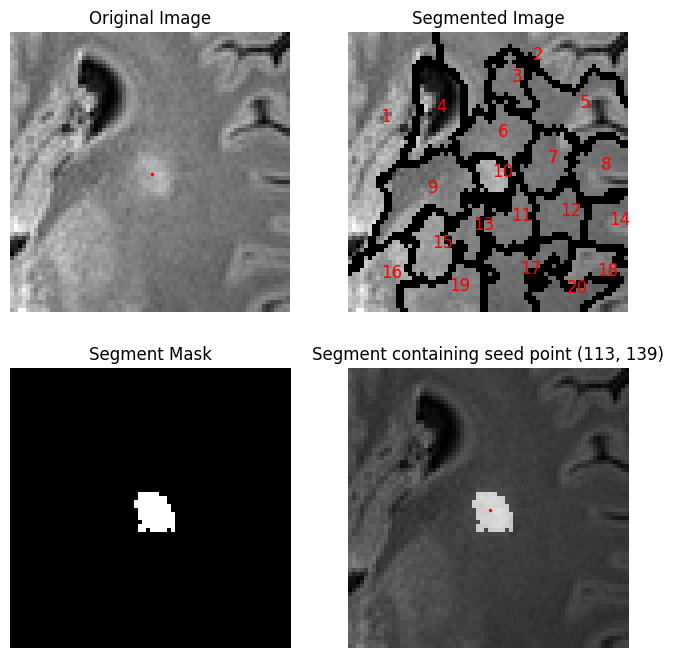

Dice Score:  0.8020833333333334
IoU Score:  0.6695652173913044
Sensitivity Score:  0.6814159292035398
Specificity Score:  0.9995822017965322
Precision Score:  0.9746835443037974
Average Hausdorff Distance:  3.1622776601683795


In [54]:
# Applying SLIC
segments_slic = segmentation.slic(crop_area(image), n_segments=50, compactness=0.02, sigma=0.1, start_label=1, channel_axis=None)

label = segmentation.mark_boundaries(crop_area(image), segments_slic, (0, 0, 0),mode="thick")

# Find the unique segments and their centroids
regions = measure.regionprops(segments_slic)
centroids = [region.centroid for region in regions]

# Selecting a specific segment
selected_segment_id = segments_slic[adjusted_seed]
selected_segment = np.where(segments_slic == selected_segment_id, 1, 0)

plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.imshow(crop_area(image), cmap="gray"), plt.title("Original Image"), plt.axis("off")
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=2)

plt.subplot(2, 2, 2)
plt.imshow(label, cmap="gray"), plt.title("Segmented Image"), plt.axis("off")
for reg in regions:
    centroid = reg.centroid
    plt.text(centroid[1], centroid[0], str(reg.label), color="red", fontsize=12)

plt.subplot(2, 2, 3)
plt.imshow(selected_segment, cmap="gray"), plt.title("Segment Mask"), plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(crop_area(image), cmap="gray")
plt.imshow(selected_segment, cmap="gray", alpha=0.5), plt.title(f"Segment containing seed point {seed_points[0]}"), plt.axis("off")
plt.scatter(adjusted_seed[0], adjusted_seed[1], color="red", s=2)

plt.show()

eval_print_scores(crop_area(mask), selected_segment)

### Fine-Tuning

looping through all images, checking whether the label image has sum of 0, if so, then skip the image
average out the performance over all parameters (using k-fold?) and collect the most used parameters for a patient (micro-average)

average out the performance over all patients (macro-average)


#### Data Load

In [3]:
# Loading data for each plane
def load_data(data_directory, load_limit = 5, fixed_image_size = False):
    sag_images = []
    sag_label_images = []
    cor_images = []
    cor_label_images = []
    tra_images = []
    tra_label_images = []

    folder_count = 0
    
    for folder in os.listdir(data_directory):
        if "sub" in folder and load_limit != 0:
            print(f"Processing {folder}")

            try:
                t2_vol = nib.load(data_directory + f"/{folder}/anat/{folder}_acq-T2sel_FLAIR.nii.gz")
                t2roi_vol = nib.load(data_directory + f"/{folder}/anat/{folder}_acq-T2sel_FLAIR_roi.nii.gz")
            except:
                print(f"Error loading {folder}")
                continue

            t2_data = t2_vol.get_fdata()
            t2roi_data = t2roi_vol.get_fdata()
                
            # Sagittal Plane
            for i in range(t2_data.shape[0]):
                image = t2_data[i, :, :]
                label_image = t2roi_data[i, :, :]

                if fixed_image_size and image.shape != (256, 256) and label_image.shape != (256, 256):
                    continue
                sag_images.append(image)
                sag_label_images.append(label_image)

            # Coronal Plane
            for i in range(t2_data.shape[1]):
                image = t2_data[:, i, :]
                label_image = t2roi_data[:, i, :]
                
                if fixed_image_size and image.shape != (160, 256) and label_image.shape != (256, 256):
                    continue
                cor_images.append(image)
                cor_label_images.append(label_image)

            # Transverse Plane
            for i in range(t2_data.shape[2]):
                image = t2_data[:, :, i]
                label_image = t2roi_data[:, :, i]

                if fixed_image_size and image.shape != (160, 256) and label_image.shape != (256, 256):
                    continue
                tra_images.append(image)
                tra_label_images.append(label_image)
            
            folder_count += 1
            load_limit -= 1
            print(f"Loaded {folder}, {load_limit} more to go")

    return sag_images, sag_label_images, cor_images, cor_label_images, tra_images, tra_label_images

In [3]:
current_directory = os.getcwd()
data_directory = current_directory + r"\Datasets\ds004199"
load_limit = 2

sag_images, sag_label_images, cor_images, cor_label_images, tra_images, tra_label_images = load_data(data_directory, load_limit)

print("List lengths: ", len(sag_images), len(sag_label_images), len(cor_images), len(cor_label_images), len(tra_images), len(tra_label_images))

Processing sub-00001
Loaded sub-00001, 1 more to go
Processing sub-00002
Error loading sub-00002
Processing sub-00003
Loaded sub-00003, 0 more to go
List lengths:  320 320 512 512 512 512


#### Data Filtering

In [160]:
# Pair image that has a positive lesion
for i in range(len(sag_label_images)-1, -1, -1):
    if sum(sag_label_images[i].flatten()) == 0:
        sag_images.pop(i)
        sag_label_images.pop(i)

for i in range(len(cor_label_images)-1, -1, -1):
    if sum(cor_label_images[i].flatten()) == 0:
        cor_images.pop(i)
        cor_label_images.pop(i)

for i in range(len(tra_label_images)-1, -1, -1):
    if sum(tra_label_images[i].flatten()) == 0:
        tra_images.pop(i)
        tra_label_images.pop(i)

print("List lengths: ", len(sag_images), len(sag_label_images), len(cor_images), len(cor_label_images), len(tra_images), len(tra_label_images))


List lengths:  515 515 488 488 435 435


#### Segmentation

In [30]:
def segmentation(params, seg_type="SLIC", eval_score="DSC", axis="sagittal"):
    """
    params: Dictionary of parameters for segmentation: any dictionary size
    seg_type: Type of segmentation to be used: RG, WS, FCM, SLIC, Felzenszwalb
        RG: Region Growing
            - connectivity: Connectivity of pixels (4 or 8)
            - threshold: Threshold value for region growing
        WS: Watershed
            - connectivity: Connectivity of pixels (2, 4, 8)
            - tolerance: Tolerance value for watershed
        FCM: Fuzzy C-Means
            - n_clusters: Number of clusters
            - m: Fuzziness parameter
            - error: Stopping criterion
            - maxiter: Maximum number of iterations
        SLIC: Simple Linear Iterative Clustering
            - n_segments: Number of segments
            - compactness: Balances color proximity and space proximity
            - sigma: Width of Gaussian kernel for pre-processing for each dimension of the image
        Felzenszwalb: Felzenszwalb
            - scale: Higher means larger clusters
            - sigma: Width of Gaussian kernel for pre-processing for each dimension of the image
            - min_size: Minimum component size. Enforced using postprocessing.
    eval_score: Evaluation metric to be used: DSC, IoU, SENS, SPEC, PREC, ACC, AHD
    axis: Axis of image to be segmented: sagittal, coronal, transverse
    """
    # Create a list of all possible combinations of parameters
    combinations = list(itertools.product(*(params[key] for key in params)))
    param_combinations = [dict(zip(params.keys(), combination)) for combination in combinations]
    per_image_scores = []
    param_ranking = {json.dumps(item): 0 for item in param_combinations}

    # Define data based on axis
    if axis == "sagittal":
        data = sag_images
        label_data = sag_label_images
    elif axis == "coronal":
        data = cor_images
        label_data = cor_label_images
    elif axis == "transverse":
        data = tra_images
        label_data = tra_label_images

     # Start computation time tracking
    start_time = time.time() 

    # Loop through all combinations of parameters on each image
    for i in range(len(data)):
        
        # Label Seedpoint per image
        seed_points = find_seeds(label_data[i])
        temp_scores = []

        if seg_type == "RG":
            for param in param_combinations:
                # print(f"Segmenting with {seg_type} by {param}")
                seg_score = evaluate(region_growing(data[i], label_data[i], seed_points, param), 
                                     label_data[i], metric=eval_score)
                temp_scores.append(seg_score)
        
        elif seg_type == "WS":
            for param in param_combinations:
                # print(f"Segmenting with {seg_type} by {param}")
                seg_score = evaluate(watershed(data[i], label_data[i], seed_points, param), 
                                     label_data[i], metric=eval_score)
                temp_scores.append(seg_score)

        elif seg_type == "FCM":
            for param in param_combinations:
                # print(f"Segmenting with {seg_type} by {param}")
                seg_score = evaluate(fuzzy_cmeans(data[i], label_data[i], seed_points, param), 
                                     label_data[i], metric=eval_score)
                temp_scores.append(seg_score)

        elif seg_type == "SLIC":
            for param in param_combinations:
                # print(f"Segmenting with {seg_type} by {param}")
                seg_score = evaluate(slic(data[i], label_data[i], seed_points, param), 
                                     label_data[i], metric=eval_score)
                temp_scores.append(seg_score)

        elif seg_type == "Felzenszwalb":
            for param in param_combinations:
                # print(f"Segmenting with {seg_type} by {param}")
                seg_score = evaluate(felzenszwalb(data[i], label_data[i], seed_points, param), 
                                     label_data[i], metric=eval_score)
                temp_scores.append(seg_score)

        # Append per image scores and param_combinations
        
        per_image_scores.append(max(temp_scores))
        param_ranking[json.dumps(param_combinations[temp_scores.index(max(temp_scores))])] += 1
        # print(f"Image {i+1} processed with {seg_type} by {param_combinations[temp_scores.index(max(temp_scores))]}")
        # print(temp_scores)
        # print(param_ranking)
    
    # End computation time tracking
    end_time = time.time()
    computation_time = end_time - start_time

    # Average score of all images with the best parameters
    best_params = max(param_ranking, key=param_ranking.get)
    best_params = json.loads(best_params)
    
    avg_scores = []
    best_param_masks = []
    
    if seg_type == "RG":
        for i in range(len(data)):
            best_param_masks.append(region_growing(data[i], label_data[i], seed_points, best_params))
            avg_scores.append(evaluate(best_param_masks[i], label_data[i], metric=eval_score))
        best_img = avg_scores.index(max(avg_scores))
        plt.figure(figsize=(8, 8)), plt.subplot(1, 2, 1), plt.imshow(data[best_img], cmap="gray"), plt.imshow(label_data[best_img], cmap="gray", alpha=0.5)
        plt.subplot(1, 2, 2), plt.imshow(data[best_img], cmap="gray")
        plt.imshow(region_growing(data[best_img], label_data[best_img], find_seeds(label_data[best_img]), best_params), cmap="gray", alpha=0.5)
        plt.show()
        
    
    elif seg_type == "WS":
        for i in range(len(data)):
            best_param_masks.append(watershed(data[i], label_data[i], seed_points, best_params))
            avg_scores.append(evaluate(best_param_masks[i], label_data[i], metric=eval_score))
        best_img = avg_scores.index(max(avg_scores))
        plt.figure(figsize=(8, 8)), plt.subplot(1, 2, 1), plt.imshow(data[best_img], cmap="gray"), plt.imshow(label_data[best_img], cmap="gray", alpha=0.5)
        plt.subplot(1, 2, 2), plt.imshow(data[best_img], cmap="gray")
        plt.imshow(watershed(data[best_img], label_data[best_img], find_seeds(label_data[best_img]), best_params), cmap="gray", alpha=0.5)
        plt.show()
    
    elif seg_type == "FCM":
        for i in range(len(data)):
            best_param_masks.append(fuzzy_cmeans(data[i], label_data[i], seed_points, best_params))
            avg_scores.append(evaluate(best_param_masks[i], label_data[i], metric=eval_score))
        best_img = avg_scores.index(max(avg_scores))
        plt.figure(figsize=(8, 8)), plt.subplot(1, 2, 1), plt.imshow(data[best_img], cmap="gray"), plt.imshow(label_data[best_img], cmap="gray", alpha=0.5)
        plt.subplot(1, 2, 2), plt.imshow(data[best_img], cmap="gray")
        plt.imshow(fuzzy_cmeans(data[best_img], label_data[best_img], find_seeds(label_data[best_img]), best_params), cmap="gray", alpha=0.5)
        plt.show()
    
    elif seg_type == "SLIC":
        for i in range(len(data)):
            best_param_masks.append(slic(data[i], label_data[i], seed_points, best_params))
            avg_scores.append(evaluate(best_param_masks[i], label_data[i], metric=eval_score))
        best_img = avg_scores.index(max(avg_scores))
        plt.figure(figsize=(8, 8)), plt.subplot(1, 2, 1), plt.imshow(data[best_img], cmap="gray"), plt.imshow(label_data[best_img], cmap="gray", alpha=0.5)
        plt.subplot(1, 2, 2), plt.imshow(data[best_img], cmap="gray")
        plt.imshow(slic(data[best_img], label_data[best_img], find_seeds(label_data[best_img]), best_params), cmap="gray", alpha=0.5)
        plt.show()
    
    elif seg_type == "Felzenszwalb":
        for i in range(len(data)):
            best_param_masks.append(felzenszwalb(data[i], label_data[i], seed_points, best_params))
            avg_scores.append(evaluate(best_param_masks[i], label_data[i], metric=eval_score))            
        best_img = avg_scores.index(max(avg_scores))
        plt.figure(figsize=(8, 8)), plt.subplot(1, 2, 1), plt.imshow(data[best_img], cmap="gray"), plt.imshow(label_data[best_img], cmap="gray", alpha=0.5)
        plt.subplot(1, 2, 2), plt.imshow(data[best_img], cmap="gray")
        plt.imshow(felzenszwalb(data[best_img], label_data[best_img], find_seeds(label_data[best_img]), best_params), cmap="gray", alpha=0.5)
        plt.show()

    
    average_score = sum(avg_scores) / len(avg_scores)
    best_score = max(avg_scores)

    return computation_time, best_params, average_score, best_score


#### Performance Evaluation

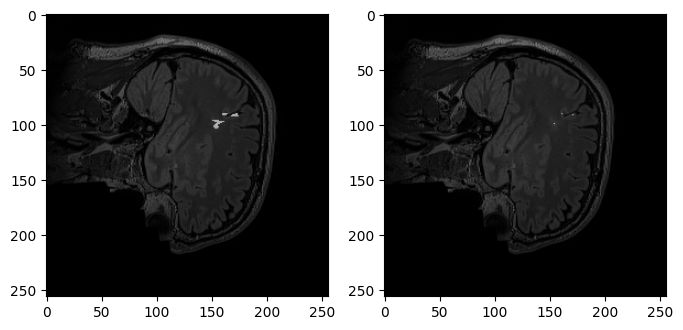

Compuation Time: 2.3065402507781982
Best Parameters: {'connectivity': 4, 'threshold': 0.0001}
Average Score: 0.0037002332556602575
Best Score: 0.031746031746031744


In [31]:
# Region Growing
params = {
    "connectivity": [4, 8],
    "threshold": [0.0001, 0.001, 0.05, 0.1, 1, 3, 5, 10, 22, 30]
}

comp_time, best_params, avg_score, best_score = segmentation(params, seg_type="RG", eval_score="DSC", axis="sagittal")

print(f"Computation Time: {comp_time}")
print(f"Best Parameters: {best_params}")
print(f"Average Score: {avg_score}")
print(f"Best Score: {best_score}")

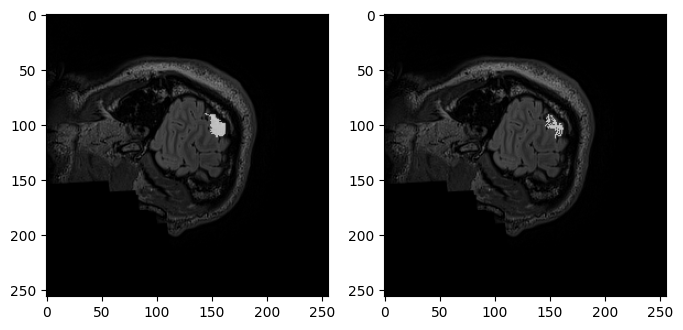

Compuation Time: 5.8439507484436035
Best Parameters: {'connectivity': 2, 'tolerance': 10}
Average Score: 0.15659434027626512
Best Score: 0.6548672566371682


In [33]:
# Watershed
params = {
    "connectivity": [2, 4, 8],
    "tolerance": [0.1, 1, 3, 5, 10, 22, 30, 50, 100]
}

comp_time, best_params, avg_score, best_score = segmentation(params, seg_type="WS", eval_score="DSC", axis="sagittal")

print(f"Computation Time: {comp_time}")
print(f"Best Parameters: {best_params}")
print(f"Average Score: {avg_score}")
print(f"Best Score: {best_score}")

In [7]:
# Fuzzy C-Means
params = {
    "n_clusters": [2, 4, 6, 8],
    "m": [1.1, 1.3, 1.5],
    "error": [0.0001, 0.001, 0.01, 0.1],
    "maxiter": [100, 1000, 10000]
}

comp_time, best_params, avg_score, best_score = segmentation(params, seg_type="FCM", eval_score="DSC", axis="sagittal")

print(f"Computation Time: {comp_time}")
print(f"Best Parameters: {best_params}")
print(f"Average Score: {avg_score}")
print(f"Best Score: {best_score}")

Image 0 processed with FCM by {'n_clusters': 2, 'm': 1.1, 'error': 0.0001, 'maxiter': 100}
Image 1 processed with FCM by {'n_clusters': 2, 'm': 1.1, 'error': 0.0001, 'maxiter': 100}
Image 2 processed with FCM by {'n_clusters': 2, 'm': 1.1, 'error': 0.0001, 'maxiter': 100}
Image 3 processed with FCM by {'n_clusters': 2, 'm': 1.1, 'error': 0.0001, 'maxiter': 100}
Image 4 processed with FCM by {'n_clusters': 2, 'm': 1.1, 'error': 0.001, 'maxiter': 1000}
Image 5 processed with FCM by {'n_clusters': 2, 'm': 1.1, 'error': 0.0001, 'maxiter': 1000}
Image 6 processed with FCM by {'n_clusters': 2, 'm': 1.1, 'error': 0.0001, 'maxiter': 1000}
Image 7 processed with FCM by {'n_clusters': 2, 'm': 1.1, 'error': 0.001, 'maxiter': 100}
Image 8 processed with FCM by {'n_clusters': 2, 'm': 1.1, 'error': 0.0001, 'maxiter': 100}
Image 9 processed with FCM by {'n_clusters': 2, 'm': 1.1, 'error': 0.001, 'maxiter': 1000}
Image 10 processed with FCM by {'n_clusters': 2, 'm': 1.1, 'error': 0.0001, 'maxiter': 10

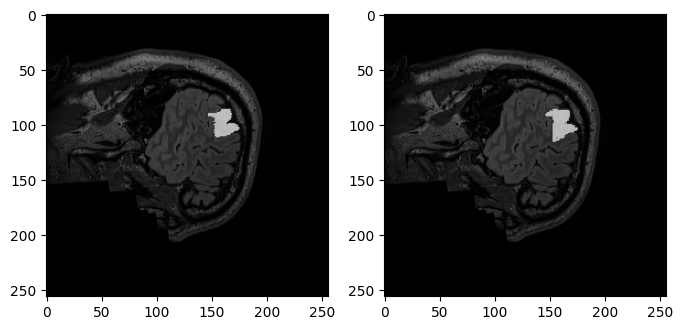

Compuation Time: 563.7103478908539
Best Parameters: {'n_segments': 200, 'compactness': 0.04, 'sigma': 0.5}
Average Score: 0.1534486710958345
Best Score: 0.8752834467120182


In [35]:
# SLIC
params = {
    "n_segments": [50, 100, 200, 500, 1000, 3000],
    "compactness": [0.01, 0.02, 0.04, 0.07, 0.4, 1],
    "sigma": [0.1, 0.5, 1]
}

comp_time, best_params, avg_score, best_score = segmentation(params, seg_type="SLIC", eval_score="DSC", axis="sagittal")

print(f"Computation Time: {comp_time}")
print(f"Best Parameters: {best_params}")
print(f"Average Score: {avg_score}")
print(f"Best Score: {best_score}")

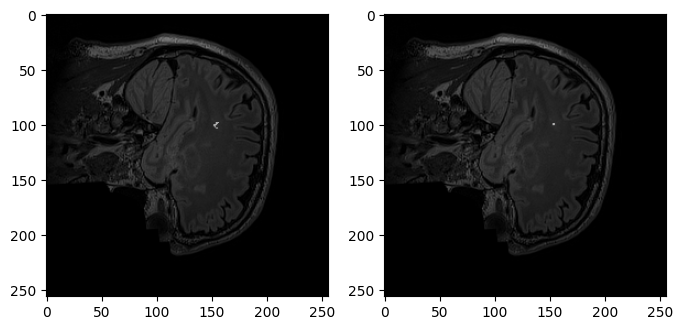

Compuation Time: 1135.3852376937866
Best Parameters: {'scale': 1, 'sigma': 0.001, 'min_size': 2}
Average Score: 0.03351998940662132
Best Score: 0.3448275862068966


In [36]:
# Felzenszwalb
params = {
    "scale": [1, 10, 25, 50, 100],
    "sigma": [0.001, 0.01, 0.1, 0.5],
    "min_size": [2, 4, 8]
}

comp_time, best_params, avg_score, best_score = segmentation(params, seg_type="Felzenszwalb", eval_score="DSC", axis="sagittal")

print(f"Computation Time: {comp_time}")
print(f"Best Parameters: {best_params}")
print(f"Average Score: {avg_score}")
print(f"Best Score: {best_score}")

# Convolutional Neural Network

### Pre-processing

In [159]:
current_directory = os.getcwd()
data_directory = current_directory + r"\Datasets\ds004199"
load_limit = 20

sag_images, sag_label_images, cor_images, cor_label_images, tra_images, tra_label_images = load_data(data_directory, load_limit, fixed_image_size=True)

print("List lengths: ", len(sag_images), len(sag_label_images), len(cor_images), len(cor_label_images), len(tra_images), len(tra_label_images))

# delete images for testing
# del cor_images, cor_label_images, tra_images, tra_label_images

Processing sub-00001
Loaded sub-00001, 19 more to go
Processing sub-00002
Error loading sub-00002
Processing sub-00003
Loaded sub-00003, 18 more to go
Processing sub-00004
Loaded sub-00004, 17 more to go
Processing sub-00005
Error loading sub-00005
Processing sub-00006
Error loading sub-00006
Processing sub-00007
Error loading sub-00007
Processing sub-00008
Error loading sub-00008
Processing sub-00009
Loaded sub-00009, 16 more to go
Processing sub-00010
Loaded sub-00010, 15 more to go
Processing sub-00011
Error loading sub-00011
Processing sub-00012
Error loading sub-00012
Processing sub-00013
Error loading sub-00013
Processing sub-00014
Error loading sub-00014
Processing sub-00015
Loaded sub-00015, 14 more to go
Processing sub-00016
Error loading sub-00016
Processing sub-00017
Error loading sub-00017
Processing sub-00018
Error loading sub-00018
Processing sub-00019
Error loading sub-00019
Processing sub-00020
Error loading sub-00020
Processing sub-00021
Error loading sub-00021
Process

In [161]:
def split_data(images, label_images, test_size=0.4, val_size=0.5, random_state=42):
    # Shuffling data
    images, label_images = shuffle(images, label_images, random_state=random_state)

    # Split data into training and a combined validation/test set
    train_images, val_test_images, train_labels, val_test_labels = train_test_split(
        images, label_images, test_size=test_size, random_state=random_state)

    # Further split the combined validation/test set into separate validation and test sets
    val_images, test_images, val_labels, test_labels = train_test_split(
        val_test_images, val_test_labels, test_size=val_size, random_state=random_state)

    return train_images, val_images, test_images, train_labels, val_labels, test_labels

sag_train_images, sag_val_images, sag_test_images, sag_train_labels, sag_val_labels, sag_test_labels = split_data(sag_images, sag_label_images)
del sag_images, sag_label_images

cor_train_images, cor_val_images, cor_test_images, cor_train_labels, cor_val_labels, cor_test_labels = split_data(cor_images, cor_label_images)
del cor_images, cor_label_images

tra_train_images, tra_val_images, tra_test_images, tra_train_labels, tra_val_labels, tra_test_labels = split_data(tra_images, tra_label_images)
del tra_images, tra_label_images

sag_train_images = np.array(sag_train_images)
sag_train_labels = np.array(sag_train_labels)
sag_val_images = np.array(sag_val_images)
sag_val_labels = np.array(sag_val_labels)
sag_test_images = np.array(sag_test_images)
sag_test_labels = np.array(sag_test_labels) 
print(sag_train_images.shape, sag_train_labels.shape)

sag_train_images = sag_train_images.reshape((-1, 256, 256, 1))  # Reshape to include the channel dimension
sag_train_labels = sag_train_labels.reshape((-1, 256, 256, 1))  # Do the same for labels
sag_val_images = sag_val_images.reshape((-1, 256, 256, 1))
sag_val_labels = sag_val_labels.reshape((-1, 256, 256, 1))
sag_test_images = sag_test_images.reshape((-1, 256, 256, 1))
sag_test_labels = sag_test_labels.reshape((-1, 256, 256, 1))

print(sag_train_images.shape, sag_train_labels.shape)

(309, 256, 256) (309, 256, 256)
(309, 256, 256, 1) (309, 256, 256, 1)


### Simple Model

In [184]:
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(256, 256, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    Conv2D(512, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    Conv2D(1024, (3, 3), activation="relu", padding="same"),

    UpSampling2D((2, 2)),
    Conv2D(512, (3, 3), activation="relu", padding="same"),
    UpSampling2D((2, 2)),
    Conv2D(256, (3, 3), activation="relu", padding="same"),
    UpSampling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu", padding="same"),
    UpSampling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu", padding="same"),
    UpSampling2D((2, 2)),
    Conv2D(32, (3, 3), activation="relu", padding="same"),
    Conv2D(1, (1, 1), activation="sigmoid")
])

# Compile the model
model.compile(optimizer=Adam(),
            loss="binary_crossentropy",
            metrics=[MeanIoU(num_classes=2)])

In [185]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_225 (Conv2D)         (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_90 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_226 (Conv2D)         (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_91 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_227 (Conv2D)         (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_92 (MaxPoolin  (None, 32, 32, 128)    

In [186]:
history = model.fit(np.array(sag_train_images).reshape(-1, 256, 256, 1), 
          np.array(sag_train_labels).reshape(-1, 256, 256, 1), 
          epochs=5, batch_size=32, 
          validation_data=(np.array(sag_val_images).reshape(-1, 256, 256, 1), 
                           np.array(sag_val_labels).reshape(-1, 256, 256, 1)))

Epoch 1/5
10/10 [==============================] - 10s 981ms/step - loss: 2.7845 - mean_io_u_7: 0.2798 - val_loss: 0.0998 - val_mean_io_u_7: 0.2500
Epoch 2/5
10/10 [==============================] - 9s 910ms/step - loss: 0.0552 - mean_io_u_7: 0.2500 - val_loss: 0.0217 - val_mean_io_u_7: 0.2500
Epoch 3/5
10/10 [==============================] - 9s 919ms/step - loss: 0.0186 - mean_io_u_7: 0.2500 - val_loss: 0.0157 - val_mean_io_u_7: 0.2500
Epoch 4/5
10/10 [==============================] - 9s 897ms/step - loss: 0.0156 - mean_io_u_7: 0.2500 - val_loss: 0.0147 - val_mean_io_u_7: 0.2500
Epoch 5/5
10/10 [==============================] - 9s 901ms/step - loss: 0.0149 - mean_io_u_7: 0.2500 - val_loss: 0.0143 - val_mean_io_u_7: 0.2500


In [187]:
score = model.evaluate(np.array(sag_test_images).reshape(-1, 256, 256, 1))
print(f"Test Score: {score}")


4/4 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mean_io_u_7: 0.0000e+00
Test Score: [0.0, 0.0]


In [ ]:
predicted_masks = []

for i in range(len(sag_test_images)):
    test_mask = model.predict(sag_test_images[i].reshape(-1, 256, 256, 1), verbose=0)
    ten_percent_mask = test_mask > np.percentile(test_mask, 99.9)
    ten_percent_mask = ten_percent_mask.astype(int).reshape(256, 256, 1)
    predicted_masks.append(ten_percent_mask)

labels_flat = sag_test_labels.flatten()
predicted_masks_flat = np.array(predicted_masks).flatten()

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   6728774
         1.0       0.06      0.02      0.03     21434

    accuracy                           1.00   6750208
   macro avg       0.53      0.51      0.51   6750208
weighted avg       0.99      1.00      0.99   6750208



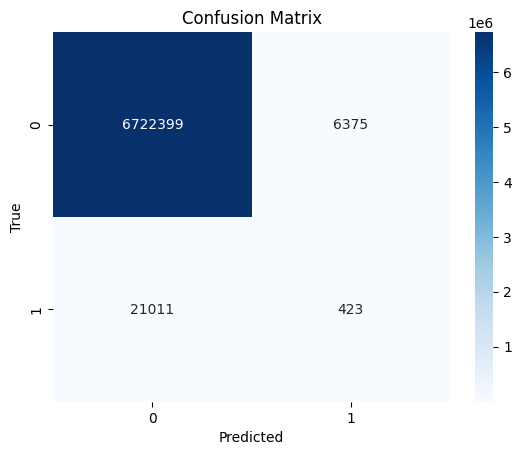

In [229]:
print(classification_report(labels_flat, predicted_masks_flat))

cm = confusion_matrix(labels_flat, predicted_masks_flat)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 22ms/step
(1, 256, 256, 1)
0.030288226673180263


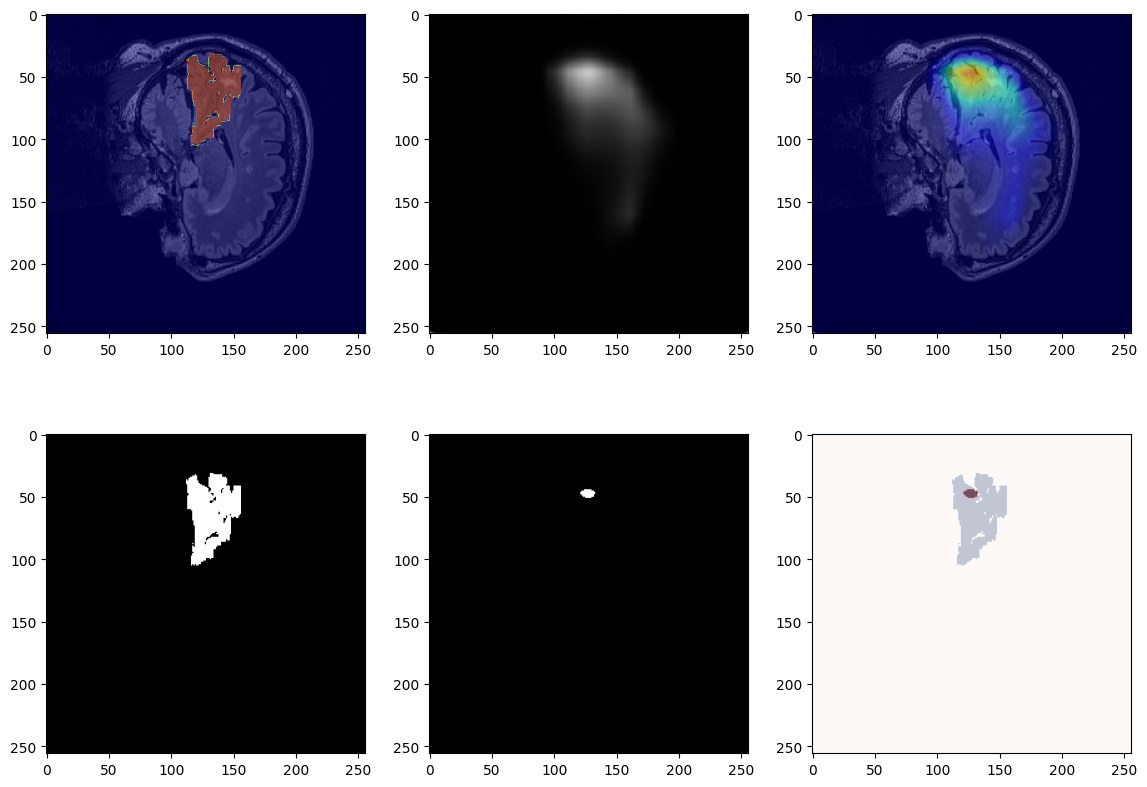

In [223]:
# i = 345
i = 12
test = sag_train_images[i].reshape(-1, 256, 256, 1)

# print(test.shape)
# print(np.max(test))

predicted_mask = model.predict(test)
print(predicted_mask.shape)
test_mask = predicted_mask.reshape(256, 256)

# print(test_mask)
# print(np.max(test_mask))

test_mask_mean = np.mean(test_mask)
mean_mask = test_mask > test_mask_mean
ten_percent_mask = test_mask > np.percentile(test_mask, 99.9)
ten_percent_mask = ten_percent_mask.astype(int).reshape(256, 256, 1)

# print(ten_percent_mask)
# print(np.max(ten_percent_mask))
# print(np.min(ten_percent_mask))
# print(np.max(sag_train_labels[i].astype(int)))
# print(np.min(sag_train_labels[i].astype(int)))
# print(ten_percent_mask.shape)
# print((sag_train_labels[i].astype(int)).shape)

print(evaluate(sag_train_labels[i].astype(int), ten_percent_mask, metric="IoU"))

plt.figure(figsize=(14, 10))

plt.subplot(2, 3, 1)
plt.imshow(sag_train_images[i], cmap='gray')
plt.imshow(sag_train_labels[i], cmap='jet', alpha=0.5)

plt.subplot(2, 3, 2)
plt.imshow(test_mask, cmap='gray')

plt.subplot(2, 3, 3)
plt.imshow(sag_train_images[i], cmap='gray')
plt.imshow(test_mask, cmap='jet', alpha=0.5) 

plt.subplot(2, 3, 4)
plt.imshow(sag_train_labels[i], cmap='gray')

plt.subplot(2, 3, 5)
plt.imshow(ten_percent_mask, cmap='gray')

plt.subplot(2, 3, 6)
plt.imshow(sag_train_labels[i], cmap='Blues', alpha=0.5)
plt.imshow(ten_percent_mask, cmap='Reds',alpha=0.5)
plt.show()

### U-Net

#### ResNet50

In [ ]:
def expand_grayscale_to_rgb(x):
    # Replicate the grayscale channel to create an RGB-like tensor
    x = tf.keras.backend.repeat_elements(x, 3, axis=-1)
    return x

def encoder(input_shape):
    # Define a custom input layer that accepts grayscale images
    inputs = Input(shape=input_shape)

    # Expand the grayscale images to 3 channels
    x = Lambda(expand_grayscale_to_rgb)(inputs)

    # Load ResNet50 with weights pre-trained on ImageNet
    encoder = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=x)

    # Define layers for skip connections
    skip_connection_layers = ['conv1_relu', 'conv2_block3_out', 'conv3_block4_out', 'conv4_block6_out']
    encoder_outputs = [encoder.get_layer(name).output for name in skip_connection_layers]

    return inputs, encoder_outputs

def decoder(encoder_outputs):
    # Start from the last output of the encoder
    x = encoder_outputs[-1]  # Last layer of encoder

    # Define the number of filters in each convolutional block
    num_filters = [256, 128, 64, 32]

    # Add Upsampling, Concatenation and Conv2D layers
    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        if i < len(encoder_outputs) - 1:  # Check if skip connection is available
            x = concatenate([x, encoder_outputs[-(i + 2)]])  # Skip connection
        x = Conv2D(f, (3, 3), activation='relu', padding='same')(x)
    return x

def unet(input_shape):
    inputs, encoder_outputs = encoder(input_shape)
    x = decoder(encoder_outputs)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)  # Assuming binary segmentation

    model = Model(inputs, outputs)
    return model

input_shape = (256, 256, 1)  # Example input shape, adjust as needed
unet_model = unet(input_shape)
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
unet_model.fit(sag_train_images, sag_train_labels, epochs=5, validation_data=(sag_val_images, sag_val_labels))


#### VGG16

In [23]:
def expand_grayscale_to_rgb(x):
    # Replicate the grayscale channel to create an RGB-like tensor
    x = tf.keras.backend.repeat_elements(x, 3, axis=-1)
    return x

def encoder(input_shape):
    inputs = Input(shape=input_shape)
    x = Lambda(expand_grayscale_to_rgb)(inputs)

    # Load VGG16 (or another VGG variant) with weights pre-trained on ImageNet
    encoder = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_tensor=x)

    # Define layers for skip connections (after each pooling layer)
    skip_connection_layers = ['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool']
    encoder_outputs = [encoder.get_layer(name).output for name in skip_connection_layers]

    return inputs, encoder_outputs

def decoder(encoder_outputs):
    # Start from the last output of the encoder
    x = encoder_outputs[-1]  # Last layer of encoder

    # Define the number of filters in each convolutional block
    num_filters = [512, 256, 128, 64]

    # Add Upsampling, Concatenation and Conv2D layers
    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        if i < len(encoder_outputs) - 1:  # Check if skip connection is available
            x = concatenate([x, encoder_outputs[-(i + 2)]])  # Skip connection
        x = Conv2D(f, (3, 3), activation='relu', padding='same')(x)
    return x

def unet(input_shape):
    inputs, encoder_outputs = encoder(input_shape)
    x = decoder(encoder_outputs)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)  # Assuming binary segmentation

    model = Model(inputs, outputs)
    return model

input_shape = (256, 256, 1)  # Example input shape, adjust as needed
unet_model = unet(input_shape)
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
unet_model.fit(sag_train_images, sag_train_labels, epochs=5, validation_data=(sag_val_images, sag_val_labels))


Epoch 1/5
60/60 [==============================] - 1015s 17s/step - loss: 2.8301 - accuracy: 0.9824 - val_loss: 0.1801 - val_accuracy: 0.9994
Epoch 2/5
60/60 [==============================] - 951s 16s/step - loss: 0.0493 - accuracy: 0.9988 - val_loss: 0.0145 - val_accuracy: 0.9994
Epoch 3/5
60/60 [==============================] - 884s 15s/step - loss: 0.0250 - accuracy: 0.9992 - val_loss: 0.0402 - val_accuracy: 0.9994
Epoch 4/5
60/60 [==============================] - 1029s 17s/step - loss: 0.0188 - accuracy: 0.9994 - val_loss: 0.0135 - val_accuracy: 0.9994
Epoch 5/5
60/60 [==============================] - 1206s 20s/step - loss: 0.0099 - accuracy: 0.9993 - val_loss: 0.0497 - val_accuracy: 0.9994


In [24]:
test_IoU = unet_model.evaluate(np.array(sag_test_images).reshape(-1, 256, 256, 1))
print(f"Test IoU: {test_IoU}")

20/20 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Test IoU: [0.0, 0.0]


#### Segmentation Plot

(1, 256, 256, 1)
371.9968870729208
1/1 [==============================] - 0s 21ms/step


(1, 256, 256, 1)


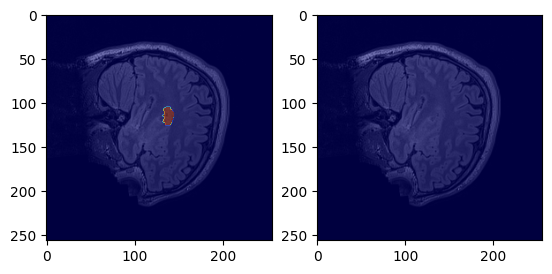

In [32]:
image = 115
test = sag_images[image].reshape(-1, 256, 256, 1)
print(test.shape)
print(np.max(test))

predicted_mask = unet_model.predict(test)
print(predicted_mask.shape)
test_mask = predicted_mask.reshape(256, 256)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(sag_images[image], cmap='gray')
plt.imshow(sag_label_images[image], cmap='jet', alpha=0.5)

plt.subplot(1, 2, 2)
plt.imshow(sag_images[image], cmap='gray')
plt.imshow(test_mask, cmap='jet', alpha=0.5) 
plt.show()